---
# **Image Captioning Model Development**

---
I. 캡션 텍스트 시퀀스 데이터에 대해 전처리와 토큰화를 합니다. 그리도 embedding vector를 준비합니다 (텍스트 시퀀스 데이터는 나중에 임베딩 되고 LSTM에서 처리됩니다).

II. 사전 훈련된 CNN 모델 InceptionV3를 사용하여 이미지 특성들을 추출합니다 (추출된 이미지 특성들은 나중에 LSTM 결과/출력과 병합됩니다).

III. 이미지 특성 데이터와 텍스트 시퀀스 데이터를 Train/Test 데이터로 나눕니다. 그리고 Train 텍스트 데이터를 기준으로 단어-인덱스 사전을 만들고 전체 단어 개수와 최대 캡션 길이를 구합니다. 이 때, 최소 빈도수 threshold를 설정해 학습에 사용할 단어 수를 줄이기도 합니다.

IV. 모델을 구현(define)합니다. 이 때, 준비한 embedding vector를 사용해 모든 단어에 대한 embedding matrix를 만들어 모델의 embedding layer에 적용합니다.

V. 모델을 학습시킵니다.

VI. 훈련된 모델을 사용해 이미지 캡션을 생성해 모델에 대한 정성적 평가를 합니다. Greedy Search와 Beam Search 모두를 사용합니다.

VII. BLEU 평가를 통해 모델에 대한 정량적 평가를 합니다.

---

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# change working directory
%cd /content/drive/MyDrive/Colab Notebooks/video_captioning5
!pwd

/content/drive/MyDrive/Colab Notebooks/video_captioning5
/content/drive/MyDrive/Colab Notebooks/video_captioning5


In [ ]:
# check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
print('-------------------------------------------')
print('-------------------------------------------')
# check tensorflow/keras version
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)

Mon Feb  7 10:32:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
---
# **I. 데이터 읽기**
---
---

## **1. AI Hub 멀티모달 데이터셋**

총 600,103개
- Part_01 : 165,743개 정보
- Part_02 : 150,920개 정보
- Part_03 : 124,899개 정보
- Part_04 : 158,541개 정보

```
- 모든 이미지들을 한 곳에 옮겨 모아두는 것은 시간이 매우 오래 걸릴 것으로 예상
- 여러 폴더에 흩어져 있는 이미지들을 읽는 것은 이미지 특성 추출 때, 하나씩 해당 경로에서 읽어들이는 것이 나을 것으로 생각 됨
- 탐색하면서 각 이미지 위치/경로를 이미지 ID로 가져오고, description text도 동시에 가져와 필요한 데이터 준비
```

In [ ]:
import os
import glob
import time
import json

base_dir = '/content/drive/MyDrive/Colab Notebooks/data'

img_full_desc_dict = {}

for main_file in os.scandir(base_dir):
    # data 디렉토리에서 조회한 파일이 폴더이고 'Part_'로 시작한다면 
    if main_file.is_dir() and main_file.name.startswith('Part_'):
        # 각 데이터셋 폴더(Part_01~04)에 대한 반복문 실행
        for video_info_set in os.scandir(main_file.path):
            # Part_ directory 하위에 KETI_MULTIMODAL로 된 모든 영상 정보 폴더 조회
            if video_info_set.is_dir() and video_info_set.name.startswith('KETI_MULTIMODAL'):
                # 'KETI_MULTIMODAL_'로 된 이름이 비디오 이름/id이기도 하니 따로 변수로 저장
                video_id = video_info_set.name
                # 각 KETI_MULTIMODAL 폴더 하위의 파일들 조회 (image folder, json files, mp4 있음)
                for it in os.scandir(video_info_set.path):
                    # 해당 파일이 directory가 아닌 file이며, '비디오 id_interpolation.json'으로 된 파일이라면
                    if it.is_file() and it.name == video_id + '_interpolation.json':
                        # 해당 json파일로 path 지정하고
                        path_to_json = it.path
                        # descriptions 모으는 작업 시작
                        try:
                            # json 파일 읽기
                            with open(path_to_json, 'r', encoding='UTF8') as f:
                                json_data = json.load(f)

                            # 정보 중 shot_infos 정보를 가져오고
                            for shot_info in list(json_data['shot_infos']):
                                shot_id = shot_info['image_folder']
                                if shot_info['visual_infos'] != None:
                                    # 그 중 visual_infos 정보를 가져오고
                                    for visual_info in shot_info['visual_infos']:
                                        # 거기서 image_id와 image_descs 가져와 dictionary에 저장
                                        # image_id는 dictionary에 key로 저장할 때, 앞에 shot id를 붙여서 입력
                                        image_id = os.path.join(video_info_set.path, video_id, shot_id, visual_info['image_id'])
                                        # json 파일에 이미지 정보는 있지만 이미지가 존재하지 않는 것 그리고 image description 정보 없는 것 처리해 주기 
                                        if os.path.exists(image_id) and len(visual_info['image_descs']):
                                            image_descs = visual_info['image_descs']
                                            img_full_desc_dict[image_id] = image_descs
                        except Exception as et:
                            print("Error while getting data:", et, ' : ', it.path)
                            continue
print(len(img_full_desc_dict))

# pickle로 저장
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/video_captioning4/img_full_desc_dict.pkl', "wb") as fp:
    pickle.dump(img_full_desc_dict, fp)

598914


In [ ]:
# 저장한 pickle 다시 불러오기
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/video_captioning4/img_full_desc_dict1.pkl', "rb") as fp:
    img_full_desc_dict = pickle.load(fp)

In [ ]:
list(img_full_desc_dict.items())[:1]

[('/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000448.jpg',
  ['남자들이 있다',
   '남자들은 서로 쳐다보고있다',
   '남자는 검정머리이다',
   '남자는 흰 셔츠를 입고있다',
   '남자는 옆을 보고있다'])]

## **2. AI Hub MSCOCO 이미지 설명 데이터셋**

총 123,287개
- train2014 : 82,783개 정보
- val2014 : 40,504개 정보

```
- AI Hub의 MSCOCO 이미지 설명 데이터셋은 MSCOCO 이미지는 포함되어 있지 않고 별도로 받아오거나 크롤링 필요
- 이미지들을 폴더에 저장하는 것이 필요하기 때문에, 이미지 ID로 이미지 파일 이름 그대로 사용
- 이미지 그리고 json 데이터가 준비되면, 각 이미지 파일 이름과 description text만 가져와 필요한 데이터 준비
```

### MSCOCO 한국어 캡션 데이터 읽기

In [ ]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/data/MSCOCO_train_val_Korean.json', 'r', encoding='UTF8') as f:
  json_data = json.load(f)

print(len(json_data))

123287


In [ ]:
json_data[0]

{'caption_ko': ['빨간 헬멧을 쓴 남자가 작은 모터 달린 비포장 도로를 달려 있다.',
  '시골의 비포장 도로에서 오토바이를 타는 남자',
  '오토바이 뒤에 탄 남자',
  '오토바이 위에 젊은이가 탄 비포장 도로는 다리가 있는 초록빛 지역의 전경과 구름 낀 산의 배경이 있다.',
  '빨간 셔츠와 빨간 모자를 쓴 남자가 언덕 쪽 오토바이 위에 있다.'],
 'captions': ['A man with a red helmet on a small moped on a dirt road. ',
  'Man riding a motor bike on a dirt road on the countryside.',
  'A man riding on the back of a motorcycle.',
  'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ',
  'A man in a red shirt and a red hat is on a motorcycle on a hill side.'],
 'file_path': 'val2014/COCO_val2014_000000391895.jpg',
 'id': 391895}

In [ ]:
json_data[0]['file_path']

'val2014/COCO_val2014_000000391895.jpg'

- 위 코드와 같이 json파일을 열고 데이터 개수를 확인한 결과 약 12만 개였다. 그리고 첫 번째 데이터를 살펴보면 5개의 문장이 한국어와 영어 버전으로 있는 것을 확인할 수 있다. 
- 또한 그 밑에 'file_path'라는 것이 있는데 이 부분이 바로 이미지의 url 주소 일부이다. 이미지를 다운로드 받기 위해선 이 데이터가 필요하다.

### MSCOCO 이미지 다운로드 및 저장
- train/validaion 2014 이미지 데이터

In [ ]:
import requests
import urllib.request
import urllib
import os
import time
import tqdm

In [ ]:
# 이미지 저장을 위한 image_caption 폴더 생성
os.mkdir('/content/drive/MyDrive/Colab Notebooks/video_captioning5/images')

In [ ]:
# 현재 경로 이동
%cd /content/drive/MyDrive/Colab Notebooks/video_captioning5/images
!pwd

/content/drive/MyDrive/Colab Notebooks/video_captioning5/images
/content/drive/MyDrive/Colab Notebooks/video_captioning5/images


In [ ]:
# MSCOCO 이미지 데이터셋 불러오기
# train2014 / val2014
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip

--2022-01-30 14:17:47--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.46.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.46.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  16.2MB/s    in 13m 50s 

2022-01-30 14:31:37 (15.5 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2022-01-30 14:31:37--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.230.75
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.230.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  15.8MB/s    in 7m 31s  

2022-01-30 14:39:09 (14.1 MB/s) - ‘

In [ ]:
# 압축 해제
import zipfile
zipfile.ZipFile('train2014.zip').extractall() # .namelist()
zipfile.ZipFile('val2014.zip').extractall()

In [ ]:
len(os.listdir('/content/drive/MyDrive/Colab Notebooks/video_captioning5/images/train2014'))

82783

In [ ]:
len(os.listdir('/content/drive/MyDrive/Colab Notebooks/video_captioning5/images/val2014'))

40504

In [ ]:
# 개수 확인
print(len(json_data))
print(82783+40504)

123287
123287


---
---
# **II. 데이터 전처리 및 준비**
---
---

## **한국어 캡션 텍스트 전처리 및 토큰화**
- 텍스트 전처리
- 형태소 분석
- 전체 descriptions 데이터 load 및 {image id:[descriptions]} 형태로 저장

In [ ]:
import os
import string
import glob
import pickle
import numpy as np
from time import time
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras.preprocessing.image
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Dropout, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 6.6 MB/s 
     |████████████████████████████████| 448 kB 61.8 MB/s 


In [ ]:
# 불용어 리스트
stopwords = '은 는 이 가 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓'
stopwords = stopwords.split(' ')

- 캡션 텍스트 데이터를 전처리하고 토큰화한다
- 5개의 문장을 하나의 리스트로 정리하고, 딕셔너리에 넣는다. 이 때, 해당되는 이미지 ID가 딕셔너리의 key값이 된다.

In [ ]:
json_data[0]['file_path'].split('/')[1]

'COCO_val2014_000000391895.jpg'

In [ ]:
# 의미형태소(어간추출)

# 불용어 제거 및 형태소 단위로 나누기 (의미형태소만 남기기)
# 그리고 최종적으로 원형 복원(stemming)시킨 형태소 단위로 다시 변형
import re
from tqdm import tqdm
from konlpy.tag import Okt

okt = Okt()
img_desc_dict = dict()
sent_token = []
max_length = 0
for i in tqdm(range(len(json_data))):
  id = json_data[i]['file_path'].split('/')[1] # jpg 파일 이름 추출
  descs = []
  # 한 이미지별 5개 description이 내려간다
  for desc in json_data[i]['caption_ko']: 
    # description 형태소 단위로 나누기 및 전처리
    desc = re.sub('[^가-힣 ]', '', desc) # 한글을 제외하고 다 제거
    desc = okt.morphs(desc) # 형태소 단위로 나누기
    desc = [word for word in desc if (word not in stopwords)] # 불용어 제거
    desc = ' '.join(desc) # 한 string으로 합치기
    desc_words = okt.morphs(desc, stem=True) # 다시 형태소 단위로 나누면서 어간 추출

    # 한국어 GloVe 임베딩 사전 생성용 sent_token 리스트 생성
    sent_token.append(desc_words)
    # 캡션 중 최대 길이를 갖는 캡션 길이 구해놓기
    max_length = max(max_length, len(desc_words))
    # 정리된 형태소/단어들 넣기
    desc_words = ' '.join(desc_words)
    descs.append(desc_words)
  # 이미지 이름을 key로, 5개 descs를 value로 가진 dictionary 생성 
  img_desc_dict[id] = descs # {이미지 이름/id : ['전처리 및 형태소화 된 description' string 5개 들어있는 리스트]}

# 전체 고유 단어
unique_words = set()
for token_list in img_desc_dict.values():
    [unique_words.update(token.split()) for token in token_list]

print('max length:', max_length) # 전체 기준 길이가 가장 긴 캡션의 길이
print('number of {imgae-descs}:', len(img_desc_dict)) # 총 {image:descriptions} 데이터 개수
print('img_desc_dict looks like:', list(img_desc_dict.items())[0]) # 1개의 데이터에 5개의 이미지를 가짐 / id(key)는 jpg 파일 이름
print('total number of unique words:', len(unique_words)) # 고유 단어 수

import pickle
with open("img_desc_dict.pkl", "wb") as f:
    pickle.dump(img_desc_dict, f)

100%|██████████| 123287/123287 [32:38<00:00, 62.94it/s]


max length: 39
number of {imgae-descs}: 123287
img_desc_dict looks like: ('COCO_val2014_000000391895.jpg', ['빨갛다 헬멧 쓸다 남자 작다 모터 달리다 비 포장 도로', '시골 비 포장 도로 오토바이 타다 남자', '오토바이 뒤 타다 남자', '오토바이 위 젊은이 타다 비 포장 도로 다리 있다 초록빛 지역 전경 구름 끼다 산 배경', '빨갛다 셔츠 빨갛다 모자 쓸다 남자 언덕 쪽 오토바이 위'])
total number of unique words: 15337


In [ ]:
# 의미형태소 + 기능형태소

# 기능형태소: 조사, 어미 등 문법적관계를 표현하는 형태소
import re
from tqdm import tqdm
from konlpy.tag import Okt

okt = Okt()
# null_punct = str.maketrans('', '', string.punctuation)
img_desc_dict = dict()
sent_token = []
max_length = 0
for i in tqdm(range(len(json_data))):
  id = json_data[i]['file_path'].split('/')[1] # jpg 파일 이름 추출
  descs = []
  # 한 이미지별 5개 description이 내려간다
  for desc in json_data[i]['caption_ko']: 
    # description을 형태소(의미형태소+기능형태소) 단위로 나누기 및 전처리
    desc = re.sub('[^가-힣 ]', '', desc)
    desc_words = okt.morphs(desc)

    # 임베딩용 sent_token 리스트 생성
    sent_token.append(desc_words)
    # 캡션 중 최대 길이를 갖는 캡션 길이 구해놓기
    max_length = max(max_length, len(desc_words))
    # 정리된 형태소/단어들 넣기
    desc_words = ' '.join(desc_words)
    descs.append(desc_words)
  # 이미지 이름을 key로, 5개 descs를 value로 가진 dictionary 생성 
  img_desc_dict[id] = descs # {이미지 이름/id : ['전처리 및 형태소화 된 description' string 5개 들어있는 리스트]}

# 전체 고유 단어
unique_words = set()
for token_list in img_desc_dict.values():
    [unique_words.update(token.split()) for token in token_list]

print('max length:', max_length) # 전체 기준 길이가 가장 긴 캡션의 길이
print('number of {imgae-descs}:', len(img_desc_dict)) # 총 {image:descriptions} 데이터 개수
print('img_desc_dict looks like:', list(img_desc_dict.items())[0]) # 1개의 데이터에 5개의 이미지를 가짐 / id(key)는 jpg 파일 이름
print('total number of unique words:', len(unique_words)) # 고유 단어 수

import pickle
with open("img_desc_dict2.pkl", "wb") as f:
    pickle.dump(img_desc_dict, f)

100%|██████████| 123287/123287 [28:54<00:00, 71.06it/s]


max length: 55
number of {imgae-descs}: 123287
img_desc_dict looks like: ('COCO_val2014_000000391895.jpg', ['빨간 헬멧 을 쓴 남자 가 작은 모터 달린 비 포장 도로 를 달려 있다', '시골 의 비 포장 도로 에서 오토바이 를 타는 남자', '오토바이 뒤 에 탄 남자', '오토바이 위 에 젊은이 가 탄 비 포장 도로 는 다리 가 있는 초록빛 지역 의 전경 과 구름 낀 산 의 배경 이 있다', '빨간 셔츠 와 빨간 모자 를 쓴 남자 가 언덕 쪽 오토바이 위 에 있다'])
total number of unique words: 24719


In [ ]:
# 저장한 img_desc_dict pickle 파일 다시 읽기
import pickle
with open("img_desc_dict2.pkl", "rb") as f:
    img_desc_dict = pickle.load(f)

In [ ]:
for x in sent_token[:5]:
  print(x)

['빨간', '헬멧', '을', '쓴', '남자', '가', '작은', '모터', '달린', '비', '포장', '도로', '를', '달려', '있다']
['시골', '의', '비', '포장', '도로', '에서', '오토바이', '를', '타는', '남자']
['오토바이', '뒤', '에', '탄', '남자']
['오토바이', '위', '에', '젊은이', '가', '탄', '비', '포장', '도로', '는', '다리', '가', '있는', '초록빛', '지역', '의', '전경', '과', '구름', '낀', '산', '의', '배경', '이', '있다']
['빨간', '셔츠', '와', '빨간', '모자', '를', '쓴', '남자', '가', '언덕', '쪽', '오토바이', '위', '에', '있다']


모델의 입력값으로 들어갈 이미지와 캡션을 전처리해주었다. 

---
---
# **III. 워드 임베딩 준비**
---
---

## **1. Glove 워드 임베딩 사전**
- Glove를 사용해 자체 데이터로 학습하여 한국어 임베딩 모델 및 사전 만들기
- 캡션 텍스트 데이터의 말뭉치(corpus) 만들기 (이를 위해, 문장(sentence)이 토큰화 된 형태여야 한다 e.g. [[남자가, 있다], [여자가, 있다]]) 
- 생성한 corpus를 기반으로 Glove 학습을 시켜 말뭉치 내 각 단어에 대한 밀집된 실수 벡터(dense vector)인 embedding 벡터 구하기
- 학습 시킨 모델을 사용하여 각 단어에 해당되는 임베딩 벡터를 부여하여 딕셔너리 생성

```
한국어 임베딩 사전은 간단하게 말하면 학습할 단어를 숫자로 이루어진 행렬 값을 만들고, 
그 단어에 정수를 매칭해 {'사과' : 123, '딸기' : 234} 와 같이 말 그대로 사전을 만드는 작업이다. 이 작업을 위해서 GloVe를 사용해주었다.

Glove
- GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.
- The basic premise behind Glove is that we can derive semantic relationships between words from the co-occurrence matrix.
```

In [ ]:
!pip install glove_python_binary

     |████████████████████████████████| 948 kB 5.1 MB/s 


- 임베딩을 하기 위한 모델의 파라미터 값을 설정해주어야 하는데, 아래 코드에서 중간에 no_components가 몇 차원으로 할지에 대한 부분이다. 이 부분은 나중에 캡션 생성 모델의 입력 값 차원과도 연결된다.
- 200으로 설정해주었다.

In [ ]:
len(sent_token)

127765

In [ ]:
# Glove 한국어 임베딩 사전 생성
# 워드 임베딩 방법론 중 하나인 GloVe에 대해서 직접 임베딩하는 과정
# 한국어 문장을 단어(토큰) 별로 피쳐로 바꿔서 이용하기 위해서 GloVe로 임베딩 하는 과정을 사용

from glove import Corpus, Glove
import numpy as np

# corpus 생성
# vocab(corpus, 단어사전)을 만들어주는 Corpus를 불러와줍니다.
# corpus를 위와 같이 만들어줍니다. 이 때 sent_token을 우리가 가지고 있는 토큰 데이터를 넣어주시면 됩니다.
# 단 형식은 문장(sentence)이 token 화 된 모습이어야합니다.
# corpus 라이브러리는 이 형식이 아니면 에러가 납니다.
# 문장 길이가 길고, 양 옆으로 넓은 범위까지 보기 위해서 window를 조금 큰 크기인 20으로 설정 해줬습니다.
corpus = Corpus()
corpus.fit(sent_token, window=20)

# 모델 fit
# 위와 같은 파라미터 설정으로 모델을 학습시켰습니다. 차원은 200차원, learning rate 0.01을 설정해줬습니다. 
# 이는 단어가 200차원으로 임베딩된 벡터로 나온다는 것을 설정해준 것입니다.
# glove.fit 에는 위에서 만들어준 corpus를 matrix 형태로 넣어주게 됩니다. epoch을 50으로 학습시켰습니다. 
# 학습 시간을 알아보기 위해서 %time을 앞에 넣어줬고 생략 가능합니다.
glove = Glove(no_components=200, learning_rate=0.01) # 0.05
%time glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=False)
glove.add_dictionary(corpus.dictionary)

# 모델 저장
# 단어사전에 corpus를 추가하고 저장도 해주었습니다. 
# 다른 모델과 비교하기 위해 모델 이름에 window 사이즈와 epoch을 넣어주고, .model을 붙였습니다.
glove.save('/content/drive/MyDrive/Colab Notebooks/video_captioning2' + '/glove_w20_epoch50.model')

# load glove
glove_model = Glove.load('/content/drive/MyDrive/Colab Notebooks/video_captioning2' + '/glove_w20_epoch50.model')

CPU times: user 15.1 s, sys: 0 ns, total: 15.1 s
Wall time: 3.85 s


In [ ]:
glove_model.dictionary

{'남자들은': 0,
 '마주본다': 1,
 '옷을': 2,
 '들고있다': 3,
 '남자은': 4,
 '가방을': 5,
 '책장에': 6,
 '책들이': 7,
 '많다': 8,
 '체크셔츠를': 9,
 '입었다': 10,
 '옷에': 11,
 '체크무늬가있다': 12,
 '옷걸이에': 13,
 '수건이': 14,
 '걸렸다': 15,
 '사람이': 16,
 '밖을': 17,
 '나가려한다': 18,
 '잡고있다': 19,
 '남자는무표정이다': 20,
 '남자는': 21,
 '서있다': 22,
 '셔츠를': 23,
 '머리가': 24,
 '짧다': 25,
 '셔츠는': 26,
 '흰색이다': 27,
 '책장위에': 28,
 '상자가있다': 29,
 '수건이걸려있다': 30,
 '셔츠에': 31,
 '상자가': 32,
 '놓여있다': 33,
 '걸려있다': 34,
 '말하려한다': 35,
 '파란색이다': 36,
 '파마머리다': 37,
 '무표정이다': 38,
 '줄무늬가있다': 39,
 '입을': 40,
 '벌린다': 41,
 '고개를': 42,
 '숙였다': 43,
 '가운을': 44,
 '가운은': 45,
 '박스가개가있다': 46,
 '책장은': 47,
 '갈색이다': 48,
 '벗는다': 49,
 '옆을': 50,
 '본다': 51,
 '박스가개있다': 52,
 '박스가개다': 53,
 '입고있다': 54,
 '남자의': 55,
 '주머니에': 56,
 '볼펜이있다': 57,
 '남자에게': 58,
 '말한다': 59,
 '서': 60,
 '있다': 61,
 '많이있다': 62,
 '보고': 63,
 '옆모습이다': 64,
 '혼자다': 65,
 '머리색은': 66,
 '검은색이다': 67,
 '정장을': 68,
 '입고': 69,
 '책이': 70,
 '보며': 71,
 '걷고': 72,
 '검은색': 73,
 '이다': 74,
 '머리는': 75,
 '한명이다': 76,
 '앞을': 77,
 '여성의': 78,
 '꽁지머리': 79,
 '형태이다

- 이제 불러온 모델을 가지고 이 모델이 한국어 단어들에 대해서 어떤 임베딩 벡터를 내보내는지 보고 싶은데, 이때 단순히 내장된 glove.word_vectors를 사용하거나, 단어사전을 불러오면 큰 차원, 큰 데이터 양 때문에 에러가 날 수 있다.
- 따라서 다음과 같은 코드(프로세스)를 통해서 word dictionary를 따로 만들고 pickle 저장해서 필요할 때나, 처음 보는 데이터에 대해서 워드 임베딩을 할 때 (인퍼러스 시) 등에 사용 할 수 있다.


In [ ]:
# 불러온 GloVe 모델로 word (vector) dictionary 생성

import pickle

# word vector dictionary 생성
word_vector_dict = {}
for word in glove_model.dictionary.keys():
  word_vector_dict[word] = glove_model.word_vectors[glove_model.dictionary[word]]

print('[Success !] Length of word dict: ', len(word_vector_dict))

# word_dict pickle로 저장해 두기
with open('/content/drive/MyDrive/Colab Notebooks/video_captioning2' + '/glove_word_vector_dict_200.pickle', 'wb') as f:
  pickle.dump(word_vector_dict, f)
print('[Success !] Saved word dict!')

[Success !] Length of word dict:  7681
[Success !] Saved word dict!


- 이제 종합해서 200차원 임베딩 딕셔너리를 만들어준다.

In [ ]:
# 200차원 임베딩 딕셔너리
# let's map the every word (index) to a 200-long vector, using the above trained model
embeddings_index = {} 

for word in glove_model.dictionary.keys(): # 단어를 하나씩 내리고
  embeddings = word_vector_dict[word] # 해당 단어를 word_vector_dict 딕셔너리에서 조회하여 vector 값을 가져오고
  coefs = np.asarray(embeddings, dtype='float32')
  embeddings_index[word] = coefs # embedding index 딕셔너리에 해당 단어를 key로, 조회한 vector를 value로 저장

In [ ]:
# 한 단어에 대해 200차원으로 임베딩 되었다.
print(len(list(embeddings_index.values())[0]))
print(list(embeddings_index.items())[0]) 

200
('남자들은', array([ 2.10962817e-02,  5.42624965e-02, -2.24552490e-02, -3.54389776e-03,
        5.38670830e-02,  5.01134247e-02, -1.97389908e-02,  5.10953888e-02,
        4.19044830e-02,  1.50552960e-02, -2.20612232e-02,  5.31047247e-02,
       -2.13696398e-02, -2.24055313e-02,  6.32518753e-02,  4.36173177e-05,
        2.07249746e-02, -4.54651006e-02, -6.04899116e-02,  4.95890975e-02,
       -4.52257879e-02,  1.25052929e-02,  4.55876440e-02, -2.88841575e-02,
       -5.21232411e-02, -5.32527938e-02, -4.89192009e-02,  1.95554621e-03,
       -2.24220753e-02,  5.43269776e-02,  2.22087707e-02, -1.84100308e-02,
       -5.45187555e-02,  2.58172285e-02,  3.77072883e-03,  3.05781830e-02,
       -5.71030937e-02, -5.46875782e-02, -5.32550514e-02,  3.54870446e-02,
        6.38388917e-02, -3.23228054e-02, -2.96499580e-02,  1.22069719e-03,
       -4.71025780e-02, -4.34867330e-02, -3.35226543e-02,  2.91129518e-02,
        2.67071533e-03, -3.73345613e-02, -5.01496010e-02,  6.10579178e-02,
       -5.72

## **2. FastText 워드 임베딩 사전**
- 자체 데이터로 학습하여 임베딩 모델을 만들기도 하지만, pre-trained된 임베딩 모델을 사용하는 경우도 많음
- Pre-trained 임베딩 모델인 FastText 사용하여 워드 임베딩 사전 만들기
- 이미 사전집이 만들어져 있다고 보면 되며, embedding matrix를 만들 때엔, 가지고 있는 train data의 각 단어에 대해 vector를 맵핑만 해주면 됨

```
Facebook에서 만든 word representation과 sentence classification의 효율적인 학습을 위한 라이브러리로, Word2Vec 와 같이 단어를 벡터로 만들어 준다. 
Word2Vec 과의 가장 큰 차이점은 Word2Vec 은 하나의 단어를 쪼갤 수 없는 단위로 생각한다면,
FastText 는 하나의 단어 안에도 여러 단어들이 존재할 수 있다고 가정하여 학습을 진행한다. 
또한 한국어를 포함한 157개국 언어에 대한 common crawler 와 wikipedia의 데이터를 학습한 pre-trained model을 제공하고 있다.
(https://fasttext.cc/docs/en/crawl-vectors.html)

FastText의 장점:
1. 모르는 단어(Out Of Vocabulary, OOV)에 대한 대응
FastText의 인공 신경망을 학습한 후에는 데이터 셋의 모든 단어의 각 n-gram에 대해 워드 임베딩이 된다.
이에 대한 장점으로는, 내부 단어들을 통해 모르는 단어(OOV)와의 유사도도 계산할 수 있다.
예를 들어, birthday라는 단어를 학습하지 않은 상태일 때:
- FastText: birth와 day라는 내부 단어에 대한 학습이 되었을 때 birthday에 대한 벡터를 얻을 수 있다.
- Word2Vec, GloVe: 학습 데이터에 존재하지 않는 단어에 대해서는 벡터를 얻을 수 없다.
2. 출현 빈도수가 적은 단어에 대한 대응
- Word2Vec은 등장 빈도수가 적은 단어에 대해서는 임베딩의 정확도가 떨어진다는 단점이 있다. 예를 들어 happy와happpy는 다른 단어로 인식하게 된다.
- FastText는 그 단어의 n-gram이 다른 단어의 n-gram과 겹치는 경우라면, 유사도를 계산해서 임베딩 성능을 계산한다.
```

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 3.0 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3128341 sha256=0a68cedc038e3a81283dc26522292a9d7b44690c6c4a851573d99c6d3ada6acf
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
# Pre-trained FastText 한국어 임베딩 모델 불러오기
# dimension 300 --> 200으로 줄여서 저장한 모델

import io
import fasttext
import fasttext.util
from gensim.models.fasttext import FastText

#fasttext.util.download_model('ko', if_exists='ignore')
ft = fasttext.load_model('/content/drive/MyDrive/Colab Notebooks/video_captioning3/cc.ko.200.bin')
#fasttext.util.reduce_model(ft, 200)
ft.get_dimension()

200

In [ ]:
len(ft.get_words(on_unicode_error='ignore'))

2000000

In [ ]:
len(ft.get_word_vector('남자가'))

200

In [ ]:
ft.get_word_vector('남자가') # ft['남자'] 사용해도 vector 조회 가능

array([-3.52854058e-02, -1.55033857e-01, -1.49904668e-01,  9.78652462e-02,
        1.72607169e-01,  1.39832824e-01,  2.18003511e-01, -3.64717804e-02,
        7.22925588e-02,  3.74655314e-02, -3.61886248e-02,  4.51213270e-02,
       -1.17359776e-02,  1.47880055e-02, -1.45125225e-01,  2.09454358e-01,
        6.91684783e-02,  6.11168332e-03,  4.81072813e-03,  7.97198713e-02,
        2.04121731e-02,  5.32580614e-02, -1.06921792e-01,  3.45162824e-02,
       -5.60749322e-03, -5.70837930e-02,  7.88081065e-03, -3.01640093e-01,
       -2.16540862e-02, -5.39478213e-02, -3.60849053e-02, -1.50222808e-01,
        7.12671652e-02,  1.38031662e-01,  3.40728462e-02,  5.88315353e-02,
        1.05012998e-01,  9.27448273e-03, -5.48520796e-02, -4.76762978e-03,
        3.95914391e-02,  2.79763527e-02,  6.74792305e-02,  8.47736001e-02,
       -3.11794579e-02,  4.95755374e-02,  2.45218985e-02, -1.02298826e-01,
       -4.68920991e-02, -4.61132117e-02, -3.98156419e-02,  8.22441131e-02,
        8.69256258e-02,  

In [ ]:
# 단어 사이의 유사성을 계산해 최근접 이웃 찾기
ft.get_nearest_neighbors('붉은') # 모든 단어들을 계산해서 가장 유사한 단어 10개를 나타낸다

[(0.744156539440155, '하얀'),
 (0.7191643714904785, '검은'),
 (0.7184814214706421, '푸른'),
 (0.6828296780586243, '노란'),
 (0.6769130229949951, '흰'),
 (0.6722483038902283, '삼월은'),
 (0.663327693939209, '빨간'),
 (0.6537477970123291, '파란'),
 (0.6075059771537781, '털빛이'),
 (0.6064974069595337, '수수밭을')]

In [ ]:
# 세 단어의 관계를 유추
ft.get_analogies('남자','여자','회사')

[(0.6232865452766418, '기업'),
 (0.5624406337738037, 'A사'),
 (0.5614479184150696, '주주나'),
 (0.551566481590271, '본사'),
 (0.5463069677352905, '소개The'),
 (0.5453665852546692, '법인등'),
 (0.5411682724952698, '回賜'),
 (0.5410774350166321, '합명'),
 (0.5407770872116089, '회사의'),
 (0.5394502282142639, '조직')]

---
---
# **III. 데이터 분리 및 학습 데이터 준비**
---
---

## **1. AI Hub 멀티모달 데이터셋 Train/Test 데이터 분리 및 준비**
- Images 나누기
- Descriptions 나누기
    - 나누면서 각 description 앞뒤에 start, end 표시 넣기
- 영상 기준으로 70%:30%로 나누기

In [ ]:
list(img_desc_dict.items())[:2]

[('/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000448.jpg',
  ['남자들이 있다',
   '남자들은 서로 쳐다보고있다',
   '남자는 검정머리이다',
   '남자는 흰 셔츠를 입고있다',
   '남자는 옆을 보고있다']),
 ('/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000449.jpg',
  ['남자들이 있다',
   '남자들은 서로 쳐다보고있다',
   '남자는 검정머리이다',
   '남자는 흰 셔츠를 입고있다',
   '남자는 옆을 보고있다'])]

In [ ]:
# frame(image), shot이 아닌 영상을 기준으로 train/test 분리
# 전체 영상의 70%: train / 30%: test로 진행

# 전체 영상 개수 구하기
all_videos = []
for key in img_desc_dict.keys():
    v_id = key.split('/')[8]
    if v_id not in all_videos:
        all_videos.append(v_id)
print('total videos:', len(all_videos))

# 영상 이름 train/test 나누기
train_videos = []
test_videos = []
for i in range(len(all_videos)):
    # 전체 영상의 약 70%는 train으로
    if i < round(len(all_videos)*0.68):
        train_videos.append(all_videos[i])
    # 전체 영상의 약 30%는 test로
    else:
        test_videos.append(all_videos[i])
print('train videos:', len(train_videos), '/ test videos:', len(test_videos))

# 이미지 파일명 train/test 나누기
train_img = []
test_img = []

for img_id in img_desc_dict.keys():
    v_id = img_id.split('/')[8]
    # train 80%, test 20%로 할당
    if v_id in train_videos: 
        # train 이미지 파일 이름 저장
        train_img.append(img_id)
    elif v_id in test_videos:
        # test 이미지 파일 이름 저장
        test_img.append(img_id)

print('train images:', len(train_img), '({})'.format(str(round((len(train_img) / len(img_desc_dict))*100, 1))+'%'))
print('test images:', len(test_img), '({})'.format(str(round((len(test_img) / len(img_desc_dict))*100, 1))+'%'))
# 영상을 70%:30%로 나누니, 이미지도 70%:30%로 거의 딱 맞게 나눠졌다

total videos: 150
train videos: 102 / test videos: 48
train images: 114992 (69.4%)
test images: 50751 (30.6%)


In [ ]:
train_img[:5]

['/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000448.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000449.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000450.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000451.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000452.jpg']

In [ ]:
test_img[:5]

['/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000211/KETI_MULTIMODAL_0000000211/KETI_SHOT_0000129155/KM_0000005816.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000211/KETI_MULTIMODAL_0000000211/KETI_SHOT_0000129155/KM_0000005817.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000211/KETI_MULTIMODAL_0000000211/KETI_SHOT_0000129155/KM_0000005818.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000211/KETI_MULTIMODAL_0000000211/KETI_SHOT_0000129155/KM_0000005819.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000211/KETI_MULTIMODAL_0000000211/KETI_SHOT_0000129155/KM_0000005820.jpg']

- 위에서 train_imge / test_img 리스트 나눈 것을 사용하여, img_desc_dict 딕셔너리에 train data, test data 각각에 해당되는 이미지 id와 descriptions를 가져와 다시 딕셔너리로 저장
- 이때 각 description 앞뒤에 startseq, endseq 붙이기

In [ ]:
# img_desc_dict 딕셔너리에서 train_images에 있는 train용 데이터만 가져와 다시 딕셔너리로 저장
# 딕셔너리로 저장하면서 매 description에 startseq, endseq 앞뒤에 붙이기

from tqdm import tqdm

train_descriptions = {}
test_descriptions = {}

for image_id, descs in tqdm(img_desc_dict.items()):

    if image_id in train_img:
        desc_with_start_end = []
        for desc in descs:
            desc_with_start_end.append(f'startseq {desc} endseq')
        train_descriptions[image_id] = desc_with_start_end

    elif image_id in test_img:
        desc_with_start_end = []
        for desc in descs :
            desc_with_start_end.append(f'startseq {desc} endseq')
        test_descriptions[image_id] = desc_with_start_end

print('total train descriptions:', len(train_descriptions))
print('total test descriptions:', len(test_descriptions))

# 나누고 start, end 붙여진 train/test descriptions pickle로 저장
import pickle
with open("train_descriptions.pkl", "wb") as f:
    pickle.dump(train_descriptions, f)
    
with open("test_descriptions.pkl", "wb") as f:
    pickle.dump(test_descriptions, f)

100%|██████████| 165743/165743 [06:12<00:00, 444.45it/s]


total train descriptions: 114992
total test descriptions: 50751


In [ ]:
# 저장한 train/test descriptions 다시 불러오기
with open("train_descriptions.pkl", "rb") as f:
    train_descriptions = pickle.load(f)

with open("test_descriptions.pkl", "rb") as f:
    test_descriptions = pickle.load(f)

- 위 코드를 보면 'startseq {v} endseq' 라는 부분이 있다. {v} 부분은 토큰화 된 캡션 부분인데 그 앞 뒤로 startseq와 endseq를 추가해준다. 이 부분은 바로 InceptionV3 모델로 학습시킬 때 문장의 처음과 끝을 나타내는 토큰으로 모델이 인식하도록 한 것이다.
- 따라서 모든 캡션에 대해 startseq와 endseq라는 토큰을 달아준 것이다.

In [ ]:
# 출력결과, 캡션 앞 뒤로 startseq 토큰과 endseq 토큰이 붙었음을 확인할 수 있다.
list(train_descriptions.items())[0]

('/content/drive/MyDrive/Colab Notebooks/data/Part_01/KETI_MULTIMODAL_0000000012/KETI_MULTIMODAL_0000000012/KETI_SHOT_0000145756/KM_0000000448.jpg',
 ['startseq 남자들이 있다 endseq',
  'startseq 남자들은 서로 쳐다보고있다 endseq',
  'startseq 남자는 검정머리이다 endseq',
  'startseq 남자는 흰 셔츠를 입고있다 endseq',
  'startseq 남자는 옆을 보고있다 endseq'])

## **2. AI Hub MSCOCO 이미지 설명 데이터셋 Train/Test 데이터 분리 및 준비**
- Images 나누기
- Descriptions 나누기
    - 나누면서 각 description 앞뒤에 start, end 표시 넣기
- (1) Train:Test --> 70%:30%로 나누기
- (2) Train:Validation:Test --> 70%:15%:15%로 나누기

- train2014 --> train으로 사용
- val2014 --> test로 사용

```
total: 123287
train2014: 82783 (67.1%)
val2014: 40504 (32.9%)
```

In [ ]:
len(os.listdir('/content/drive/MyDrive/Colab Notebooks/video_captioning5/images/train2014'))

82783

In [ ]:
len(os.listdir('/content/drive/MyDrive/Colab Notebooks/video_captioning5/images/val2014'))

40504

In [ ]:
list(img_desc_dict.keys())[0]

'COCO_val2014_000000391895.jpg'

In [ ]:
list(img_desc_dict.keys())[0].split('_')[1]

'val2014'

### (1) Train/Test로 나누기

In [ ]:
# 이미지 파일명 train/test 나누기
# train 70% : test 30%

train_img = []
test_img = []

for img_id in img_desc_dict.keys():
    # train 이미지 파일 이름 저장
    if img_id.split('_')[1] == 'train2014':
        train_img.append(img_id)
    # test 이미지 파일 이름 저장
    elif img_id.split('_')[1] == 'val2014':
        test_img.append(img_id)

total = (len(train_img) + len(test_img))
print('total:', total)
print('train2014:', len(train_img), '({})'.format(str(round((len(train_img) / total)*100, 1))+'%'))
print('val2014:', len(test_img), '({})'.format(str(round((len(test_img) / total)*100, 1))+'%'))

total: 123287
train2014: 82783 (67.1%)
val2014: 40504 (32.9%)


- 그리고 img_desc_dict 딕셔너리에 train data에 해당되는 이미지만 가져와서 다시 딕셔너리에 저장한다. 이때 id값을 이용해서 식별해준다.

In [ ]:
# img_desc_dict 딕셔너리에서 train_images에 있는 train용 데이터만 가져와 다시 딕셔너리로 저장
# 딕셔너리로 저장하면서 매 description에 startseq, endseq 앞뒤에 붙이기
from tqdm import tqdm

train_descriptions = {}
test_descriptions = {}

for image_id, descs in tqdm(img_desc_dict.items()):

    if image_id in train_img:
      desc_with_start_end = []
      for desc in descs:
          desc_with_start_end.append(f'startseq {desc} endseq')
      train_descriptions[image_id] = desc_with_start_end
    
    elif image_id in test_img:
      desc_with_start_end = []
      for desc in descs:
          desc_with_start_end.append(f'startseq {desc} endseq')
      test_descriptions[image_id] = desc_with_start_end

print('total train descriptions:', len(train_descriptions))
print('total test descriptions:', len(test_descriptions))

# 나누고 start, end 붙여진 train/test descriptions pickle로 저장
import pickle
with open("train_descriptions2.pkl", "wb") as f:
    pickle.dump(train_descriptions, f)

with open("test_descriptions2.pkl", "wb") as f:
    pickle.dump(test_descriptions, f)

100%|██████████| 123287/123287 [08:45<00:00, 234.82it/s]


total train descriptions: 82783
total test descriptions: 40504


In [ ]:
# 저장한 train/test descriptions 다시 불러오기
with open("train_descriptions2.pkl", "rb") as f:
    train_descriptions = pickle.load(f)

with open("test_descriptions2.pkl", "rb") as f:
    test_descriptions = pickle.load(f)

### (2) Train/Validation/Test로 나누기

In [ ]:
# 이미지 파일명 train/validation/test 나누기
# train 70% : val 15% : test 15%
# Validation 적용해서 모델링 시도를 위해 validation도 나누기

train_img = []
val_test_img = []

for img_id in img_desc_dict.keys():
    # train 이미지 파일 이름 저장
    if img_id.split('_')[1] == 'train2014':
        train_img.append(img_id)
    # test 이미지 파일 이름 저장
    elif img_id.split('_')[1] == 'val2014':
        val_test_img.append(img_id)

total = (len(train_img) + len(val_test_img))
print('total:', total)
print('train2014:', len(train_img), '({})'.format(str(round((len(train_img) / total)*100, 1))+'%'))
print('val2014:', len(val_test_img), '({})'.format(str(round((len(val_test_img) / total)*100, 1))+'%'))

total: 123287
train2014: 82783 (67.1%)
val2014: 40504 (32.9%)


In [ ]:
# test_img 리스트에 있는 테스트 이미지 파일 이름들 validation / test 나누기
# 전체에서 각각 약 15%씩 가져가도록 절반으로 나누기
val_img = []
test_img = []
for i in range(len(val_test_img)):
    # train 이미지 파일 이름 저장
    if i < round(len(val_test_img)*0.5):
        val_img.append(val_test_img[i])
    # test 이미지 파일 이름 저장
    else:
        test_img.append(val_test_img[i])

print('val images:', len(val_img), '({})'.format(str(round((len(val_img) / len(val_test_img))*100, 1))+'%'))
print('test images:', len(test_img), '({})'.format(str(round((len(test_img) / len(val_test_img))*100, 1))+'%'))

val images: 20252 (50.0%)
test images: 20252 (50.0%)


In [ ]:
print(val_img[:5])
print(test_img[:5])

['COCO_val2014_000000391895.jpg', 'COCO_val2014_000000522418.jpg', 'COCO_val2014_000000184613.jpg', 'COCO_val2014_000000318219.jpg', 'COCO_val2014_000000554625.jpg']
['COCO_val2014_000000283659.jpg', 'COCO_val2014_000000348162.jpg', 'COCO_val2014_000000390471.jpg', 'COCO_val2014_000000376206.jpg', 'COCO_val2014_000000515350.jpg']


In [ ]:
from tqdm import tqdm

val_descriptions = {}
test_descriptions = {}

for image_id, desc_with_start_end in tqdm(val_test_descriptions.items()):

    if image_id in val_img:
      val_descriptions[image_id] = desc_with_start_end
    
    elif image_id in test_img:
      test_descriptions[image_id] = desc_with_start_end

print('total val descriptions:', len(val_descriptions))
print('total test descriptions:', len(test_descriptions))

import pickle
with open("val_descriptions3.pkl", "wb") as f:
    pickle.dump(val_descriptions, f)

with open("test_descriptions3.pkl", "wb") as f:
    pickle.dump(test_descriptions, f)

100%|██████████| 40504/40504 [00:16<00:00, 2486.86it/s]


total val descriptions: 20252
total test descriptions: 20252


In [ ]:
# 저장한 train/validation/test descriptions 다시 불러오기
with open("train_descriptions2.pkl", "rb") as f:
    train_descriptions = pickle.load(f)

with open("val_descriptions3.pkl", "rb") as f:
    val_descriptions = pickle.load(f)

with open("test_descriptions3.pkl", "rb") as f:
    test_descriptions = pickle.load(f)

In [ ]:
list(train_descriptions.items())[0]

('COCO_train2014_000000057870.jpg',
 ['startseq 식당 에는 현대 식 나무 탁자 와 의자 가 있다 endseq',
  'startseq 등 이 둥근 라 탄 모양 으로 된 긴 레스토랑 탁자 가 의자 에 앉아 있다 endseq',
  'startseq 나무 의자 로 둘러싸인 식물 이 위 에 있는 긴 탁자 endseq',
  'startseq 중앙 에 회의 를 위해 꽃 을 배열 한 긴 테이블 endseq',
  'startseq 테이블 이 푸른 색 악센트 가 있는 나무 의자 로 장식 되어 있다 endseq'])



- 이제 train data에 있는 모든 캡션을 하나의 리스트로 저장한다.

In [ ]:
# 모든 (train용) descriptions(captions)을 리스트로 저장
# 학습할 train data만 진행

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
print('all train descriptions:', len(all_train_captions))

all train descriptions: 414113


In [ ]:
# 이때 빈도수가 지정한 숫자보다 적은 단어는 제외 
# 빈도수가 너무 적은 단어까지 포함시켜 학습을 하게 되면 시간이 많이 소요될 뿐만 아니라 정확도가 낮아질 수 있다.

# minimum occurrence threshold
word_count_threshold = 10 
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 13686 ==> 5388


In [ ]:
# minimum occurrence threshold
word_count_threshold = 4
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 21604 ==> 10460


- 이제 각 단어에 대해 인덱스 번호를 부여하는 딕셔너리 만들기
- 그리고 vocab_size와 max_length도 구해놓기

In [ ]:
# 모든 {단어 : 인덱스 번호} 구하기
# wordtoidx / idxtoword 딕셔너리 생성

# word mapping to integers
idxtoword = {} # {인덱스 : 단어}
wordtoidx = {} # {단어 : 인덱스}
ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
print(list(wordtoidx.items())[:5])
print(list(idxtoword.items())[:5])

# vocab size 구하기
# plus 1 to our vocabulary since we append 0 to make all captions of equal length
vocab_size = len(idxtoword) + 1
print('vocab size:', vocab_size)

# max_length 구하기
max_length = max(len(d.split()) for d in all_train_captions) # max_length +2: #start 토큰, stop 토큰 때문에 +2 
print('(description) max length: %d' % max_length)

[('startseq', 1), ('식당', 2), ('에는', 3), ('현대', 4), ('식', 5)]
[(1, 'startseq'), (2, '식당'), (3, '에는'), (4, '현대'), (5, '식')]
vocab size: 10461
(description) max length: 57


---
---
# **IV. 이미지 인코딩 및 특성 추출**
---
---

- 이미지 인코딩
- Pre-trained model인 InceptionV3 모델을 사용하여, 이미지 특성 추출



In [ ]:
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # feature shape 1280인듯
# import tensorflow.keras.applications.mobilenet_v2
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

USE_INCEPTION = True

if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet') #InceptionV3 사용
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048 #output : 2048 / OPUTPUT_DIM은 어떤 feature extraction 모델을 쓰느냐에 따라 다르다
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 1s 0us/step


이제 학습을 하기 위한 이미지를 전처리해주고 파라미터 값을 지정한다.

In [ ]:
# 이미지 인코딩 함수 만들기
def encodeImage(img):
  # 이미지 사이즈를 표준크기로 재조정
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  #  PIL 이미지를 numpy array로 변경
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # 2D array로 확장
  x = np.expand_dims(x, axis=0)
  # InceptionV3의 인풋을 위한 전처리
  x = preprocess_input(x)
  # 인코딩 벡터 반환
  x = encode_model.predict(x)
  # LSTM을 입력을 위한 shape 조정
  x = np.reshape(x, OUTPUT_DIM) # reshape from (1, 2048) to (2048, )
  return x

- 준비가 다 되었다면 아래 코드를 통해 이미지의 feature를 추출한다.

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [ ]:
# train 이미지 인코딩 및 feature 추출
root_captioning = '/content/drive/MyDrive/Colab Notebooks/video_captioning5'
train_path = os.path.join(root_captioning,f'train_image_features_{OUTPUT_DIM}.pkl')

if not os.path.exists(train_path):
  start = time()
  train_features = {}
  for image_id in tqdm(train_img): # train_img: train용 이미지 파일 이름 저장해 놓은 변수
    image_path = '/content/drive/MyDrive/Colab Notebooks/video_captioning5/images/train2014/' + image_id
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    train_features[image_id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(train_features, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
# 이미 만들어 놓았다면, 불러오기
else:
  with open(train_path, "rb") as fp:
    train_features = pickle.load(fp)

100%|██████████| 82783/82783 [5:56:07<00:00,  3.87it/s]



Generating training set took: 5:56:12.28


In [ ]:
# test 이미지 인코딩 및 feature 추출
root_captioning = '/content/drive/MyDrive/Colab Notebooks/video_captioning5'
test_path = os.path.join(root_captioning,f'test_image_features_{OUTPUT_DIM}.pkl')

if not os.path.exists(test_path):
  start = time()
  test_features = {}
  for image_id in tqdm(test_img): # test_img: test용 이미지 파일 이름 저장해 놓은 변수
    image_path = '/content/drive/MyDrive/Colab Notebooks/video_captioning5/images/val2014/' + image_id
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    test_features[image_id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(test_features, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
# 이미 만들어 놓았다면, 불러오기
else:
  with open(test_path, "rb") as fp:
    test_features = pickle.load(fp)

100%|██████████| 40504/40504 [43:05<00:00, 15.66it/s]



Generating testing set took: 0:43:07.59


In [ ]:
# test image features pickle파일 다시 읽어오기 
root_captioning = '/content/drive/MyDrive/Colab Notebooks/video_captioning5'
test_path = os.path.join(root_captioning,f'test_image_features_{OUTPUT_DIM}.pkl')
with open(test_path, "rb") as fp:
    val_test_features = pickle.load(fp)
print(len(val_test_features))

40504


In [ ]:
# test features 데이터를 validation/test로 나누기
# => train 70%/validation 15%/test 15%

from tqdm import tqdm

val_features = {}
test_features = {}

for image_id, image_feautre in tqdm(val_test_features.items()):

    if image_id in val_img:
      val_features[image_id] = image_feautre
    
    elif image_id in test_img:
      test_features[image_id] = image_feautre

print('total val image features:', len(val_features))
print('total test image features:', len(test_features))

import pickle
with open("val_image_features2_2048.pkl", "wb") as f:
    pickle.dump(val_features, f)

with open("test_image_features2_2048.pkl", "wb") as f:
    pickle.dump(test_features, f)

100%|██████████| 40504/40504 [00:16<00:00, 2485.02it/s]


total val image features: 20252
total test image features: 20252


In [ ]:
# validation / test image features 다시 읽어오기
with open("val_image_features2_2048.pkl", "rb") as fp:
    val_features = pickle.load(fp)
print(len(val_features))

with open("test_image_features2_2048.pkl", "rb") as fp:
    test_features = pickle.load(fp)
print(len(test_features))

20252
20252


---
---
# **V. 모델 구현**
---
---

- embedding matrix 구축 (model 학습간 weight matrix로 사용할 것이다)
    - (1) Glove로 만든 embedding vector dictionary를 사용하여 200차원 embedding matrix 구축
    - (2) Pre-trained FastText의 embedding vector dictionary를 사용하여 200차원 embedding matrix 구축

In [ ]:
# (1) Glove로 만든 embedding_index로 embedding matrix 구축
# 모든 단어에 대해 embedding matrix 생성

embedding_dim = 200 # 임베딩차원 = 200(=>features)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(3279, 200)

In [ ]:
# (2) FastText의 embedding vector dictionary로 embedding matrix 구축
# 모든 단어에 대해 embedding matrix 생성
embedding_dim = 200 # embedding 차원; 200 features
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = ft.get_word_vector(word) # ft[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(10461, 200)

- 모델 구현

In [ ]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Embedding, Dropout, LSTM, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Image Model (image feature model)
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1) # dropout to reduce overfitting
fe2 = Dense(256, activation='relu')(fe1) # processed by a Dense layer to produce a 256 element representation of the photo

# Language Model (caption sequence model)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # where every index gets mapped to a 200 dimensional vector; uses a mask to ignore padded values
se2 = Dropout(0.5)(se1) # dropout to reduce overfitting
se3 = LSTM(256)(se2) # RNN / the output here is of the same shape with the output of fe2
# se3 = LSTM(256, return_sequence=True)(se2) # if you want another lstm layer, you must return sequences
# se4 = Dropout(0.5)(se3)
# se5 = LSTM(256)(se4)
# se6 = Dropout(0.5)(se5)

# Decoder (feed forward model)
decoder1 = Add()([fe2, se3]) # merges the vectors from both input models
decoder2 = Dense(256, activation='relu')(decoder1) # adding another dense layer
outputs = Dense(vocab_size, activation='softmax')(decoder2) # final output Dense layer that makes a softmax prediction (generate the probability distribution) over the entire output vocabulary for the next word in the sequence

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 57, 200)      2092200     ['input_7[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

In [ ]:
# set weights for the embedding layer using the embedding matrix from (1) the embedding index made with Glove, (2) the pre-trained FastText embedding vectors
model.layers[2].set_weights([embedding_matrix]) 
model.layers[2].trainable = False # freeze it (trainable = False), before training the model, so that it does not get updated during the backpropagation

model.compile(loss='categorical_crossentropy', optimizer='adam')

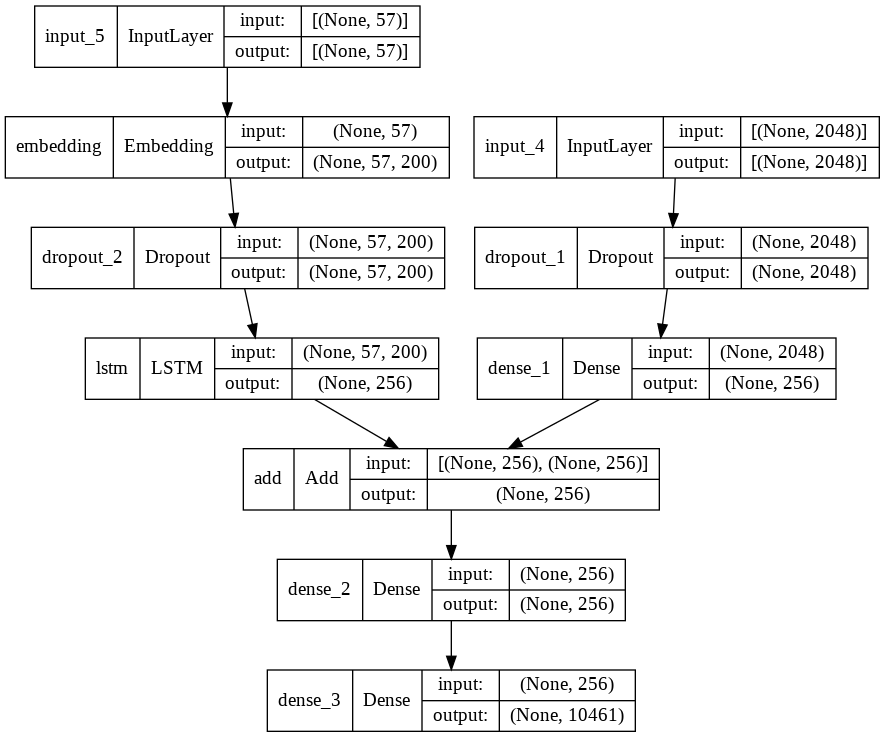

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot_5.png', show_shapes=True, show_layer_names=True)

---
---
## **VI. 모델 학습(Training the model)**
---
---

- 모델에 input, output 데이터를 제공해 줄 data generator 만들기

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

# x1 - Training data for photos
# x2 - The caption that goes with each photo
# y - The predicted rest of the caption

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            # retrieve the photo feature vectors from {image.jpg : feature vectors} dictionary 
            photo = photos[key] 
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

- 모델 학습

In [ ]:
# 모델 학습

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20
batch_size = 16 # batch_size는 16 --> 32로 조정
steps = len(train_descriptions) // batch_size

# define checkpoint callback
filepath = '/content/drive/MyDrive/Colab Notebooks/video_captioning5/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

train_generator = data_generator(train_descriptions, train_features, wordtoidx, max_length, batch_size) # train_features: {image.jpg : feature vectors}
val_generator = data_generator(val_descriptions, val_features, wordtoidx, max_length, batch_size)

model.fit(train_generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[earlystop, checkpoint], validation_data=val_generator, validation_steps=len(val_descriptions)//batch_size)

# learning rate 0.001 --> 0.0001 (1e-4)
model.optimizer.lr = 0.0001
epochs = 10
batch_size = 32 # batch_size는 16 --> 32로 조정
steps = len(train_descriptions) // batch_size

# define checkpoint callback
#filepath = '/content/drive/MyDrive/Colab Notebooks/video_captioning5/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

train_generator = data_generator(train_descriptions, train_features, wordtoidx, max_length, batch_size)
val_generator = data_generator(val_descriptions, val_features, wordtoidx, max_length, batch_size)

model.fit(train_generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint], validation_data=val_generator, validation_steps=len(val_descriptions)//batch_size)

model.save('final_model.h5')

---
---
## **VII. 결과 테스트 및 모델 평가**
---
---

### **캡션 생성**
- 캡션 생성, 요약, 기계 번역은 단어들의 연속을 예측한다. 이런 모델들의 출력은 각 단어들에 대해 사전크기의 확률 분포이다. 이 사전 크기의 확률 분포들은 문장속의 단어로 변환된다.
- 가장 가능성이 높은 출력 시퀀스를 디코딩하는 것은 그 가능성에 기초하여 가능한 모든 출력 시퀀스를 검색하는 것을 포함한다. 이때 vocab의 크기는 수백 수천, 수백만이 될때가 있다.
- 단어들의 후보 시퀀스들은 그들의 우도(likelihood)에 따라 점수화 되고, 다음 텍스트를 예측하는 것에 Greedy Search와 Beam Search을 일반적으로 사용한다.

**(1) Greedy Seaerch Decoder**

```
- Greedy search는 각 출력을 예측하는데 각 스텝에서 가장 가능성이/확률이 높은 단어를 선택한다. 
전체 vocab에서 각 단어에 대한 확률 분포를 예측하여 선택한다.
- 빠른 속도로 탐색 및 예측 과정이 완료되나 하나의 예측만을 고려하기 때문에 minor 한 변화에 영향을 받을 수 있어 최적의 예측을 하지 못활 수도 있다. 
쉽게 말해, 한 번이라도 잘못된 단어를 예측하게 되면 뒤이어 다 잘못된 예측이 될 수도 있다는 뜻이다.
- 기본적인 Sequence to sequence (이하 Seq2seq) 모델에서의 디코딩 과정은 보통 Greedy Decoding 방식을 따른다.
```

**(2) Beam Seaerch Decoder**

```
- 그리디 탐색의 단점을 보완하며, 확장된 빔 탐색도 많이 사용한다. 
빔 탐색의 각 후보 시퀀스는 모든 가능한 다음 스텝들로 확장된다. 
쉽게 말해, 가능한 모든 다음 단어/시퀀스 예측을 하는 것이다. 
그렇게 예측된 각 후보는 확률을 곱함으로써 점수가 매겨지고, 가장 확률이 높은 k개(beam size) 시퀀스가 선택되며, 다른 모든 후보들은 제거된다. 
위 절차들을 시퀀스가 끝날때까지 반복한다.
- 만약 지정한 beam size가 2 라면, 각 step에서 가장 확률 높은 2개를 선택한다.
- Greedy 탐색의 경우는 빔이 1인 탐색과 같다고 보면 된다. 
빔의 수는 일반적으로 5 또는 10을 사용하고, 빔이 클수록 타겟 시퀀스가 맞을 확률이 높지만 디코딩 속도가 떨어지게 된다.
```

- 캡션 출력 함수 생성
    - (1) Greedy Search
    - (2) Beam Search

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Greedy Search prediction
def greedy_search_prediction(photo):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx] # encode the input sequence to integer
        sequence = pad_sequences([sequence], maxlen=max_length) # pad the input; padding
        yhat = model.predict([photo, sequence], verbose=0) # predict next word
        yhat = np.argmax(yhat) # convert probability to integer
        word = idxtoword[yhat] # map/convert integer to word/text
        
        # stop if we cannot map the word
        if word is None:
          break
        
        # append as another input for generating the next word
        in_text += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# Beam Search prediction
def beam_search_prediction(image, beam_index = 3):
    start = [wordtoidx["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idxtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
# 사용할 학습된 모델 다시 불러오기
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/video_captioning5/batchsize_8/model-ep018-loss3.559.h5')

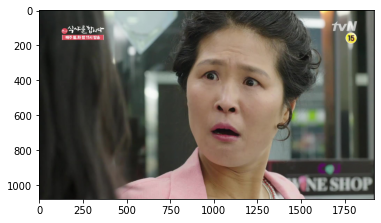

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


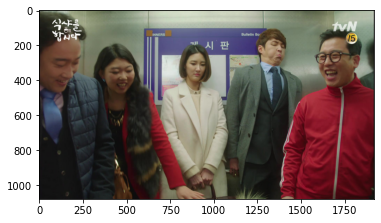

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


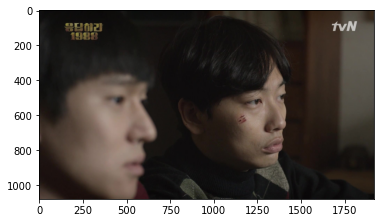

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


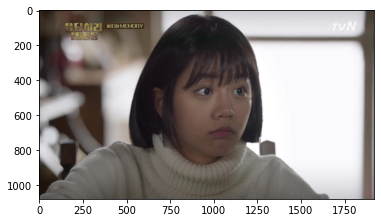

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


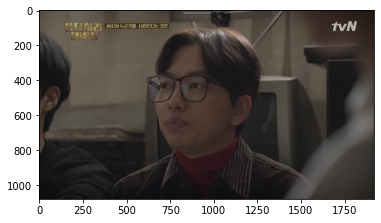

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


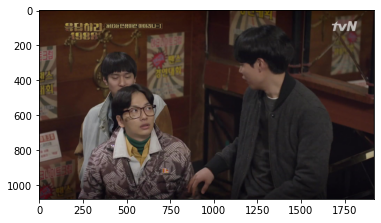

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


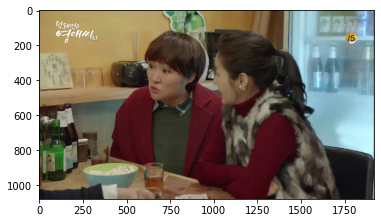

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


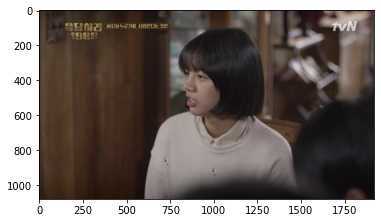

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


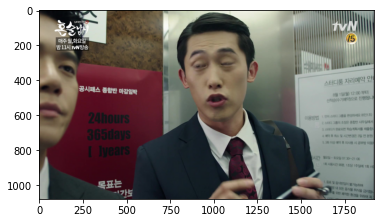

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다


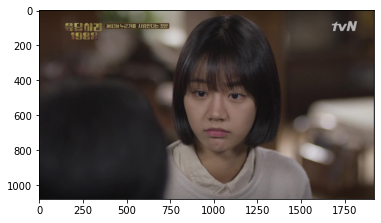

Greedy Search: 남자는 베이지색 외투를 입고 있다
Beam Search, K = 3: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 5: 여자는 베이지색 외투를 입고 있다
Beam Search, K = 7: 남자는 붉은 색을 띠는 외투를 입고 있다
Beam Search, K = 10: 남자는 붉은 색을 띠는 외투를 입고 있다
--- 185.08499145507812 seconds ---


In [ ]:
# 테스트 이미지들로 캡션 생성
import matplotlib.pyplot as plt
import random
import time

start_time = time.time()

#images_path = '/content/drive/MyDrive/Colab Notebooks/image_captioning_attention/images'

# video_captioning_4.ipynb 파일에서 진행한 드라마 영상들 test image features을 읽어와 테스트
test_path = '/content/drive/MyDrive/Colab Notebooks/video_captioning4/test_image_features_2048.pkl'
with open(test_path, "rb") as fp:
    test_features = pickle.load(fp)

for i in range(10):
    # pic = ' .jpg'
    i = random.randint(0,len(test_features))
    pic = list(test_features.keys())[i]
    image = test_features[pic].reshape((1,OUTPUT_DIM)) # OUTPUT_DIM = 2048
    #x = plt.imread(images_path + pic)
    x = plt.imread(pic)
    plt.imshow(x)
    plt.show()

    print("Greedy Search:", greedy_search_prediction(image))
    print("Beam Search, K = 3:", beam_search_prediction(image, beam_index = 3))
    print("Beam Search, K = 5:", beam_search_prediction(image, beam_index = 5))
    print("Beam Search, K = 7:", beam_search_prediction(image, beam_index = 7))
    print("Beam Search, K = 10:", beam_search_prediction(image, beam_index = 10))

print("--- %s seconds ---" % (time.time() - start_time))

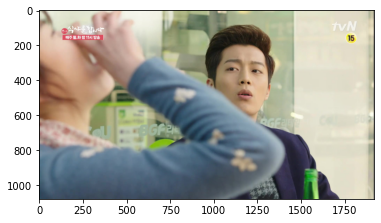

Greedy Search: 한 남자 가 그 의 머리 를 빗고 있다
Beam Search, K = 3: 한 남자 가 손 에 위키 컨트롤러 를 들고 있다
Beam Search, K = 5: 한 남자 가 손 에 위키 컨트롤러 를 들고 있다


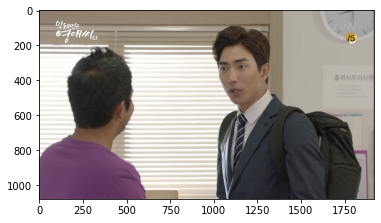

Greedy Search: 한 남자 가 휴대 전화 로 이야기 하면서 웃고 있다
Beam Search, K = 3: 정장 을 입고 넥타이 를 맨 남자 가 사진 을 찍기 위해 포즈 를 취하 고 있다
Beam Search, K = 5: 정장 을 입고 넥타이 를 맨 남자 가 사진 을 찍기 위해 포즈 를 취하 고 있다


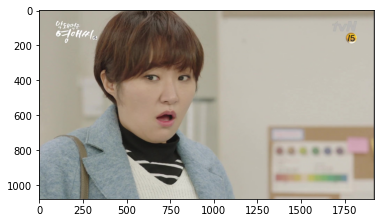

Greedy Search: 한 남자 가 휴대 전화 로 이야기 하면서 웃고 있다
Beam Search, K = 3: 안경 을 쓴 남자 가 휴대 전화 로 이야기 하고 있다
Beam Search, K = 5: 안경 을 쓴 남자 가 휴대 전화 로 이야기 하고 있다


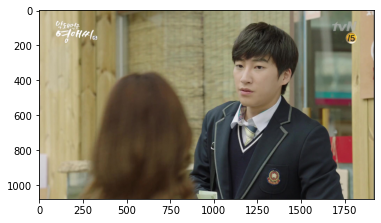

Greedy Search: 한 남자 가 휴대 전화 로 이야기 하면서 웃고 있다
Beam Search, K = 3: 정장 을 입고 넥타이 를 맨 남자 가 휴대 전화 로 이야기 하고 있다
Beam Search, K = 5: 정장 을 입고 넥타이 를 맨 남자 가 사진 을 찍기 위해 포즈 를 취하 고 있다


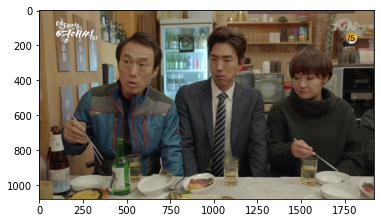

Greedy Search: 한 무리 의 사람 들 이 테이블 에 앉아 있다
Beam Search, K = 3: 한 무리 의 사람 들 이 와인 잔 을 들고 테이블 에 앉아 있다
Beam Search, K = 5: 한 무리 의 사람 들 이 와인 잔 을 들고 테이블 에 앉아 있다


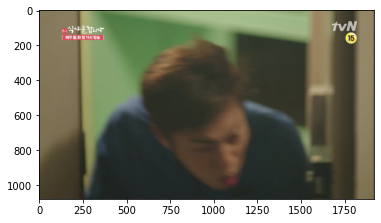

Greedy Search: 한 남자 가 그 의 머리 를 말리 고 있다
Beam Search, K = 3: 한 남자 가 비디오 게임 을 하면서 서 있다
Beam Search, K = 5: 거실 에서 비디오 게임 을 하고 있는 두 남자


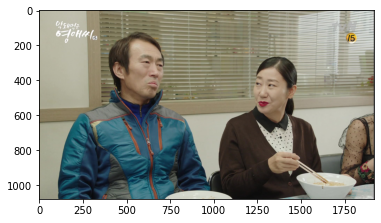

Greedy Search: 한 남자 가 와인 잔 을 들고 테이블 에 앉아 있다
Beam Search, K = 3: 한 무리 의 사람 들 이 그 들 의 결혼 케이크 를 자르고 있다
Beam Search, K = 5: 한 무리 의 사람 들 이 그 들 의 결혼 케이크 를 자르고 있다


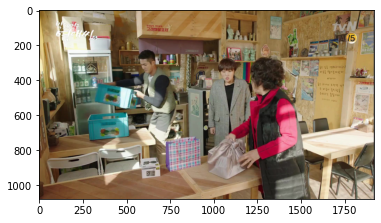

Greedy Search: 한 남자 가 부엌 에서 음식 을 준비 하고 있다
Beam Search, K = 3: 한 남자 가 그 의 부엌 에서 음식 을 준비 하고 있다
Beam Search, K = 5: 한 무리 의 사람 들 이 테이블 에 앉아 있다


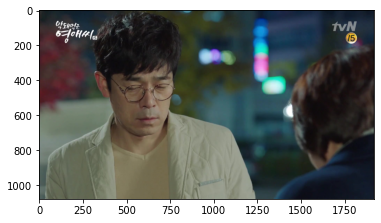

Greedy Search: 한 무리 의 사람 들 이 그 들 의 결혼 케이크 를 자르고 있다
Beam Search, K = 3: 한 무리 의 사람 들 이 그 들 의 결혼 케이크 를 자르고 있다
Beam Search, K = 5: 한 무리 의 사람 들 이 그 들 의 결혼 케이크 를 자르고 있다


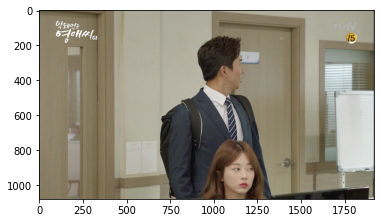

Greedy Search: 한 남자 가 그 의 휴대폰 으로 이야기 하면서 웃고 있다
Beam Search, K = 3: 한 남자 가 휴대 전화 를 귀 에 대고 있다
Beam Search, K = 5: 정장 을 입고 넥타이 를 맨 남자 가 사진 을 찍기 위해 포즈 를 취하 고 있다


In [ ]:
import random
import pickle
import matplotlib.pyplot as plt

#images_path = '/content/drive/MyDrive/Colab Notebooks/image_captioning_attention/images'

# video_captioning_4.ipynb 파일에서 진행한 드라마 영상들 test image features을 읽어와 테스트
test_path = '/content/drive/MyDrive/Colab Notebooks/video_captioning4/test_image_features_2048.pkl'
with open(test_path, "rb") as fp:
    test_features = pickle.load(fp)

for _ in range(10):
  # pic = ' .jpg'
  i = random.randint(0,len(test_features))
  pic = list(test_features.keys())[i]
  image = test_features[pic].reshape((1,OUTPUT_DIM)) # test_features: test image feature vectors / OUTPUT_DIM = 2048
  x = plt.imread(pic)
  plt.imshow(x)
  plt.show()

  print("Greedy Search:", greedy_search_prediction(image))
  print("Beam Search, K = 3:", beam_search_prediction(image, beam_index = 3))
  print("Beam Search, K = 5:", beam_search_prediction(image, beam_index = 5))
  #print("Beam Search, K = 7:", beam_search_prediction(image, beam_index = 7))
  #print("Beam Search, K = 10:", beam_search_prediction(image, beam_index = 10))

### **캡션 생성 평가**

**BLEU(Bilingual Evaluation Understudy) Score**

-  BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 이다. 측정 기준은 n-gram에 기반한다.

```
3가지 요소:
- n-gram을 통한 순서쌍들이 얼마나 겹치는지 측정(precision)
- 문장길이에 대한 과적합 보정(Brevity Penalty)
- 같은 단어가 연속적으로 나올때 과적합 되는 것을 보정(Clipping)

k를 점수를 매길 최대 길이의 n-gram 길이라고 했을 때,
개별 단어로 봤을 때, 'Ground Truth와 얼마나 공통적인 단어가 나왔는가?'를 측정
- n-gram이라고 하는 연속된 n개의 단어로 봤을 때, Ground Truth와 얼마나 겹치는 지 판단해서 계산이 진행된다. 
- 만약 k=4라면, 길이가 4이하인 n-gram에 대해서만 고려하게 될 것이다. 더 큰 길이의 n-gram은 무시한다.
- 보통 1 ~ 4의 크기의 n-Gram의 Precision을 사용한다.  
```

- BLEU 평가시 사용할 캡션 출력 함수 생성
    - Greedy Search 기반

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Greedy Search prediction
def greedy_search_for_bleu(photo):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx] # encode the input sequence to integer
        sequence = pad_sequences([sequence], maxlen=max_length) # pad the input; padding
        yhat = model.predict([photo, sequence], verbose=0) # predict next word
        yhat = np.argmax(yhat) # convert probability to integer
        word = idxtoword[yhat] # map/convert integer to word/text
        # stop if we cannot map the word
        if word is None:
          break
        # append as another input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text # bleu 평가를 위해 start, end가 그대로 붙어있는 캡션을 반환할 것이다

- BLEU 평가

In [ ]:
# BLEU 평가
# evaluate the model
from tqdm import tqdm
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.sequence import pad_sequences

def evaluate_model(model, descriptions, image_features):
  actual, predicted = list(), list()
  # step over the whole set
  for key, desc_list in tqdm(descriptions.items()):
    # generate description
    photo = image_features[key].reshape((1, OUTPUT_DIM))
    predicted_result = greedy_search_for_bleu(photo)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(predicted_result.split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# using test descriptions
evaluate_model(model, test_descriptions, test_features)

100%|██████████| 20252/20252 [2:40:30<00:00,  2.10it/s]


BLEU-1: 0.677784
BLEU-2: 0.481672
BLEU-3: 0.370388
BLEU-4: 0.236028
